Import Required Libraries

In [25]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random


Set Dataset Paths and Ensure Folders Exist

In [26]:
RAW_DATASET_DIR = r"C:\Users\Kishore\OneDrive\Desktop\DIP\Raw Dataset"
PROCESSED_DATASET_DIR = r"C:\Users\Kishore\OneDrive\Desktop\DIP\Processed Dataset"

# Ensure the processed dataset directory exists
os.makedirs(PROCESSED_DATASET_DIR, exist_ok=True)

# List the categories in the raw dataset
categories = os.listdir(RAW_DATASET_DIR)
print("Categories found in dataset:", categories)

# Create subfolders for processed data
for category in categories:
    processed_category_path = os.path.join(PROCESSED_DATASET_DIR, category)
    os.makedirs(processed_category_path, exist_ok=True)

print("Subfolders created successfully!")


Categories found in dataset: ['Non-Recyclable Waste', 'Recyclable Waste']
Subfolders created successfully!


Function to Get Image Paths from Subfolders

In [27]:
# Function to get all image paths from subfolders
def get_image_paths(root_dir):
    image_paths = []
    
    for category in os.listdir(root_dir):  # e.g., recyclable, non_recyclable
        category_path = os.path.join(root_dir, category)
        
        if os.path.isdir(category_path):  # Ensure it's a directory
            for subcategory in os.listdir(category_path):  # e.g., cardboard, glass
                subcategory_path = os.path.join(category_path, subcategory)
                
                if os.path.isdir(subcategory_path):  # Ensure it's a directory
                    for img_name in os.listdir(subcategory_path):
                        img_path = os.path.join(subcategory_path, img_name)
                        image_paths.append(img_path)
    
    return image_paths

# Get image paths from the raw dataset directory
image_paths = get_image_paths(RAW_DATASET_DIR)

# Check if images exist
if len(image_paths) == 0:
    print("No images found in subfolders.")
else:
    print(f"Found {len(image_paths)} images for processing.")


Found 1072 images for processing.


Function to Get Sample Images from Different Subfolders

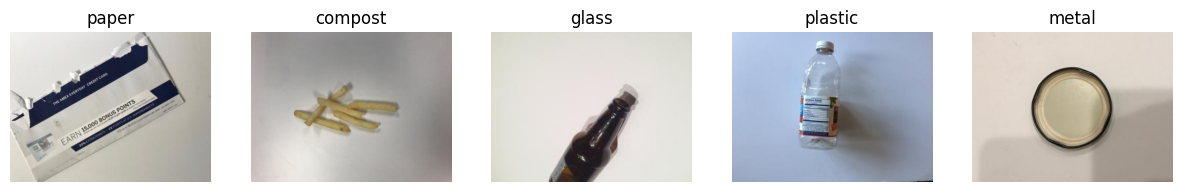

In [33]:
# Function to get images from different subfolders
def get_sample_images(image_paths, num_samples=5):
    random.shuffle(image_paths)  # Shuffle to get random images
    selected_images = []  # To store the selected images

    # Track selected subfolders to ensure diversity
    selected_subfolders = set()

    for img_path in image_paths:
        subfolder = os.path.dirname(img_path)  # Get subfolder path

        if subfolder not in selected_subfolders:
            selected_images.append(img_path)
            selected_subfolders.add(subfolder)

        if len(selected_images) == num_samples:
            break  # Stop when we get the required number of unique samples

    return selected_images

# Select 5 images from different subfolders
sample_images = get_sample_images(image_paths, num_samples=5)

# Check if enough images were found
if len(sample_images) < 5:
    print("❌ Not enough images from different subfolders.")
else:
    # Create a figure to display multiple images
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))

    for i, img_path in enumerate(sample_images):
        # Read the image
        img = cv2.imread(img_path)

        if img is None:
            print(f"❌ Error loading image: {img_path}")
            continue

        # Convert BGR to RGB for correct display
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display image in subplot
        axes[i].imshow(img_rgb)
        axes[i].set_title(f"{os.path.basename(os.path.dirname(img_path))}")  # Show folder name
        axes[i].axis("off")

    plt.show()


Preprocessing Function

In [50]:


def preprocess_image(img, target_size=(128, 128), saturation_factor=1.3, contrast_factor=1.5, sharpness_factor=2.0, edge_threshold1=100, edge_threshold2=200):
    """Resize the image, enhance its saturation, adjust contrast, sharpen it, and perform edge detection."""
    
    # Resize the image to the desired size
    img_resized = cv2.resize(img, target_size)

    # Enhance color saturation (Convert BGR to HSV)
    img_hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
    img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1] * saturation_factor, 0, 255)  # Enhance saturation
    img_enhanced = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

    # Enhance contrast (Scaling pixel values)
    img_enhanced = cv2.convertScaleAbs(img_enhanced, alpha=contrast_factor, beta=0)

    # Enhance sharpness using a kernel
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening kernel
    img_enhanced = cv2.filter2D(img_enhanced, -1, kernel)

    # Perform edge detection using Canny
    img_edges = cv2.Canny(img_enhanced, edge_threshold1, edge_threshold2)

    # Convert edges to 3 channels to match the original image
    img_edges_colored = cv2.cvtColor(img_edges, cv2.COLOR_GRAY2BGR)

    # Combine the edge-detected image with the enhanced image (Optional: you can adjust the blending here)
    img_combined = cv2.addWeighted(img_enhanced, 0.7, img_edges_colored, 0.3, 0)

    return img_combined


 Function for Object Detection with Bounding Boxes

In [51]:
def detect_objects(img, min_area=500):
    """Detect objects using contour detection and draw red bounding boxes around significant objects."""
    
    # Convert to grayscale for contour detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to remove noise while preserving edges
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply adaptive threshold for better object segmentation
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If no objects are detected, return None and indicate no detection
    if len(contours) == 0:
        return None, False

    # Draw bounding boxes for significant objects
    img_with_contours = img.copy()
    for contour in contours:
        area = cv2.contourArea(contour)

        if area > min_area:  # Ignore small contours
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(img_with_contours, (x, y), (x+w, y+h), (0, 0, 255), 3)  # Red boxes

    return img_with_contours, True


Process and Save All Images

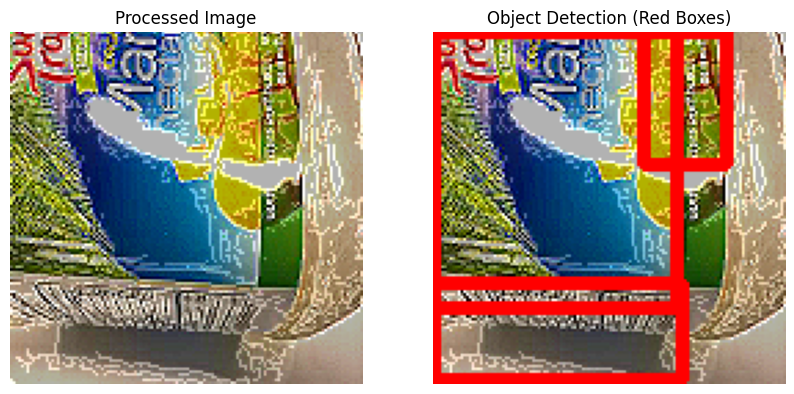

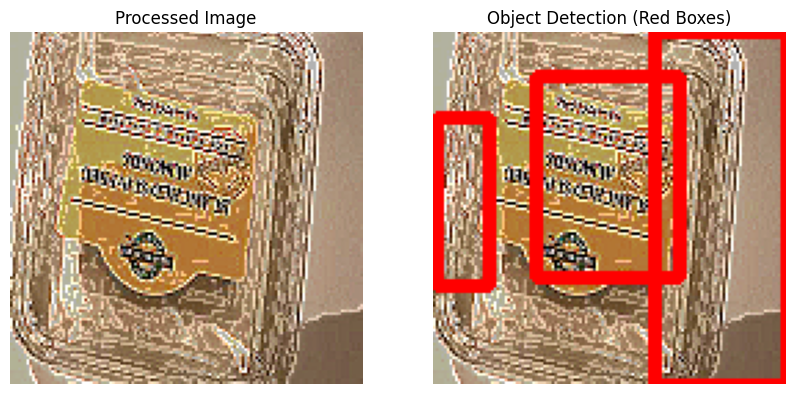

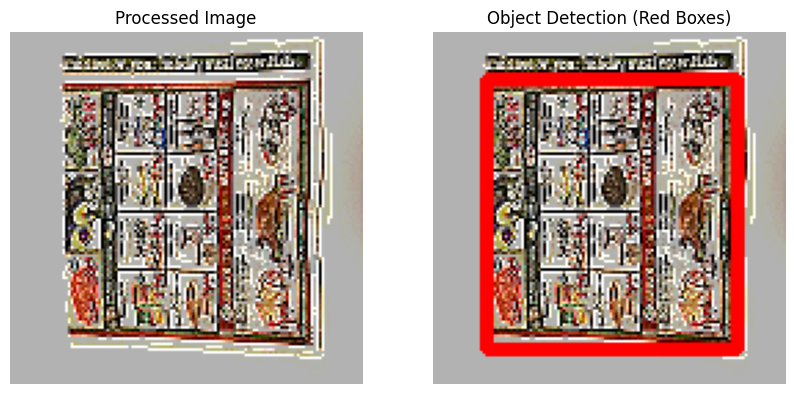

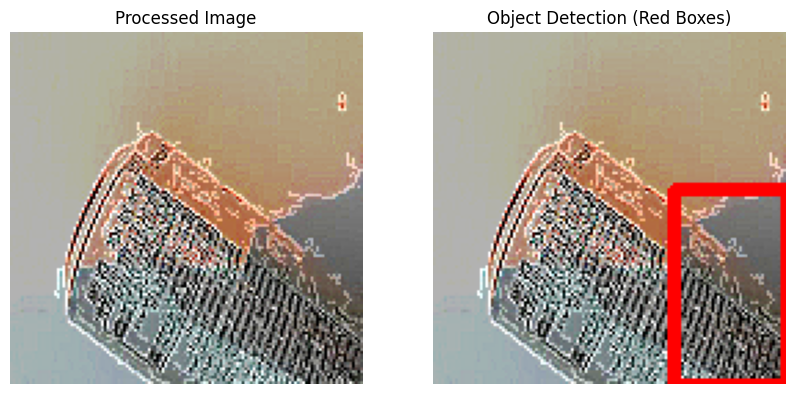

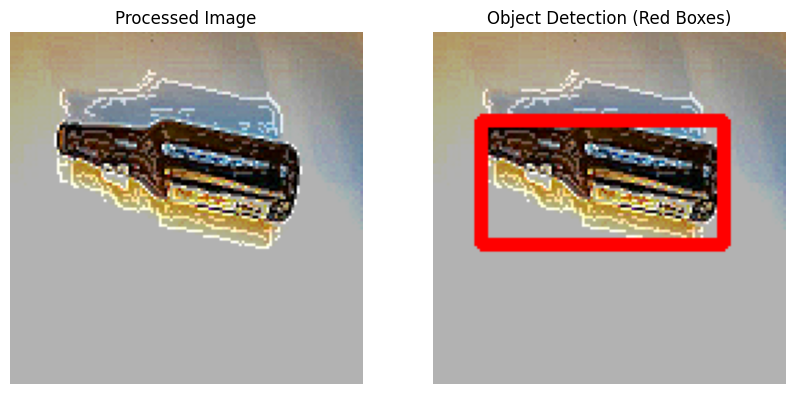

✅ 1072 images processed, 5 samples displayed, and all saved successfully!


In [52]:


# Select 5 random images for display
sample_image_paths = random.sample(image_paths, min(5, len(image_paths)))

# Process and save all images
for img_path in image_paths:
    relative_path = os.path.relpath(img_path, RAW_DATASET_DIR)  # Get relative path
    processed_img_path = os.path.join(PROCESSED_DATASET_DIR, relative_path)  # Destination path

    # Ensure the processed image directory exists
    os.makedirs(os.path.dirname(processed_img_path), exist_ok=True)

    # Read the image
    img = cv2.imread(img_path)

    if img is None:
        print(f"❌ Skipping {img_path} (Invalid Image)")
        continue  

    # Resize and enhance saturation
    img_processed = preprocess_image(img)

    # Detect objects and add red bounding boxes
    img_detected, detected = detect_objects(img_processed)

    # If no objects are detected, delete the image
    if not detected:
        print(f"❌ No objects detected in {img_path}. Deleting image.")
        os.remove(img_path)  # Delete the image file
        continue  # Skip to the next image

    # Display only the selected random images
    if img_path in sample_image_paths:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        ax[0].imshow(cv2.cvtColor(img_processed, cv2.COLOR_BGR2RGB))
        ax[0].set_title("Processed Image")
        ax[0].axis("off")

        ax[1].imshow(cv2.cvtColor(img_detected, cv2.COLOR_BGR2RGB))
        ax[1].set_title("Object Detection (Red Boxes)")
        ax[1].axis("off")

        plt.show()

    # Save processed image
    cv2.imwrite(processed_img_path, img_detected)

print(f"✅ {len(image_paths)} images processed, 5 samples displayed, and all saved successfully!")
